Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [16]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [17]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [18]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [19]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [23]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_lamda = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels], stddev=0.1))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf_lamda*tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Deciding the value of lamda is non-trivial. We should try multiple values to find out one which works.

Initialized
Test accuracy: 89.3%
Initialized
Test accuracy: 89.2%
Initialized
Test accuracy: 89.4%
Initialized
Test accuracy: 89.2%
Initialized
Test accuracy: 89.3%
Initialized
Test accuracy: 89.2%
Initialized
Test accuracy: 89.2%
Initialized
Test accuracy: 89.3%
Initialized
Test accuracy: 89.2%
Initialized
Test accuracy: 89.2%
Initialized
Test accuracy: 89.1%
Initialized
Test accuracy: 89.2%
Initialized
Test accuracy: 89.1%
Initialized
Test accuracy: 89.1%
Initialized
Test accuracy: 89.1%
Initialized
Test accuracy: 89.1%
Initialized
Test accuracy: 89.0%
Initialized
Test accuracy: 89.0%
Initialized
Test accuracy: 88.9%
Initialized
Test accuracy: 88.7%
Initialized
Test accuracy: 88.6%
Initialized
Test accuracy: 88.4%
Initialized
Test accuracy: 88.3%
Initialized
Test accuracy: 88.1%
Initialized
Test accuracy: 87.8%
Initialized
Test accuracy: 87.6%
Initialized
Test accuracy: 87.2%
Initialized
Test accuracy: 86.9%
Initialized
Test accuracy: 86.5%
Initialized
Test accuracy: 85.8%


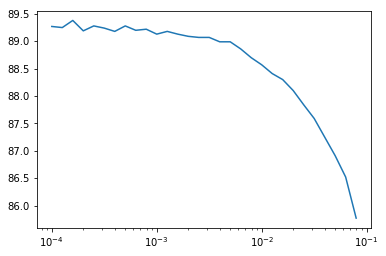

In [24]:
num_steps = 3001
lamdas = [pow(10, i) for i in np.arange(-4, -1, 0.1)]
#lamda = 0.0000001

accuracies = []

for lamda in lamdas:
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lamda : lamda}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
#         if (step % 500 == 0):
#           print("Minibatch loss at step %d: %f" % (step, l))
#           print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
#           print("Validation accuracy: %.1f%%" % accuracy(
#             valid_prediction.eval(), valid_labels))
      accuracies.append(accuracy(test_prediction.eval(), test_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

plt.semilogx(lamdas, accuracies)
plt.show()

In [29]:
max_accuracy = np.max(accuracies)
i = accuracies.index(max_accuracy)
print(max_accuracy)
print ('lamda = ', lamdas[i])

89.38
lamda =  0.000158489319246


This test accuracy for L2 regularization of logisitic regression for the same number of iterations gives us a slightly better test accuracy. Below, we try regularization for Neural Network.

In [32]:
batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_lamda = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size], stddev=0.1))
  biases1 = tf.Variable(tf.zeros([hidden_size]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels], stddev=0.1))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer1 = tf.matmul(tf_train_dataset, weights1) + biases1
  relu_output = tf.nn.relu(layer1)
  logits = tf.matmul(relu_output, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
               + tf_lamda*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2)+biases2)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2)+biases2)

Initialized
Test accuracy: 94.2%
Initialized
Test accuracy: 94.4%
Initialized
Test accuracy: 94.2%
Initialized
Test accuracy: 94.1%
Initialized
Test accuracy: 94.3%
Initialized
Test accuracy: 94.2%
Initialized
Test accuracy: 94.2%
Initialized
Test accuracy: 94.4%
Initialized
Test accuracy: 94.2%
Initialized
Test accuracy: 94.1%
Initialized
Test accuracy: 93.9%
Initialized
Test accuracy: 93.8%
Initialized
Test accuracy: 93.4%
Initialized
Test accuracy: 93.1%
Initialized
Test accuracy: 92.8%
Initialized
Test accuracy: 92.5%
Initialized
Test accuracy: 92.1%
Initialized
Test accuracy: 91.7%
Initialized
Test accuracy: 91.3%
Initialized
Test accuracy: 90.8%


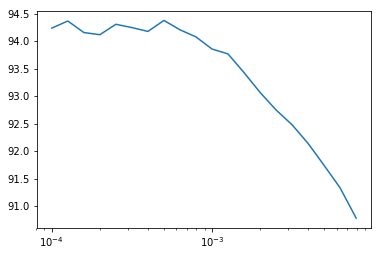

In [33]:
num_steps = 3001
lamdas = [pow(10, i) for i in np.arange(-4, -2, 0.1)]

accuracies = []

for lamda in lamdas:
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lamda: lamda}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
#         if (step % 500 == 0):
#           print("Minibatch loss at step %d: %f" % (step, l))
#           print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
#           print("Validation accuracy: %.1f%%" % accuracy(
#             valid_prediction.eval(), valid_labels))
      
      accuracies.append(accuracy(test_prediction.eval(), test_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

plt.semilogx(lamdas, accuracies)
plt.show()

In [34]:
max_accuracy = np.max(accuracies)
i = accuracies.index(max_accuracy)
print(max_accuracy)
print ('lamda = ', lamdas[i])

94.38
lamda =  0.000501187233627


This test accuracy for L2 regularization of neural network for the same number of iterations gives us a slightly better test accuracy. Below, we try regularization for Neural Network.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [64]:
batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_lamda = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size]))
  biases1 = tf.Variable(tf.zeros([hidden_size]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer1 = tf.matmul(tf_train_dataset, weights1) + biases1
  relu_output = tf.nn.relu(layer1)
  logits = tf.matmul(relu_output, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) 
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2)+biases2)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2)+biases2)

In [65]:
num_steps = 101
lamda = 0
num_batches = 2

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
   
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lamda: lamda}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))

  accuracies.append(accuracy(test_prediction.eval(), test_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 317.402435
Minibatch accuracy: 9.4%
Validation accuracy: 38.0%
Test accuracy: 79.9%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [66]:
batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_lamda = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size]))
  biases1 = tf.Variable(tf.zeros([hidden_size]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer1 = tf.matmul(tf_train_dataset, weights1) + biases1
  relu_output = tf.nn.relu(layer1)
  dropout_output = tf.nn.dropout(relu_output, 0.5)
  logits = tf.matmul(dropout_output, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
               + tf_lamda*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2)+biases2)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2)+biases2)

In [67]:
num_steps = 101
lamda = 0
num_batches = 2

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
   
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lamda: lamda}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))

  accuracies.append(accuracy(test_prediction.eval(), test_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 534.541626
Minibatch accuracy: 7.0%
Validation accuracy: 24.8%
Minibatch loss at step 10: 55.937737
Minibatch accuracy: 87.5%
Validation accuracy: 73.1%
Minibatch loss at step 20: 10.855789
Minibatch accuracy: 94.5%
Validation accuracy: 74.1%
Minibatch loss at step 30: 8.063570
Minibatch accuracy: 93.8%
Validation accuracy: 73.0%
Minibatch loss at step 40: 4.904087
Minibatch accuracy: 96.1%
Validation accuracy: 72.9%
Minibatch loss at step 50: 9.732141
Minibatch accuracy: 96.9%
Validation accuracy: 74.6%
Minibatch loss at step 60: 1.779456
Minibatch accuracy: 97.7%
Validation accuracy: 74.2%
Minibatch loss at step 70: 1.742350
Minibatch accuracy: 97.7%
Validation accuracy: 73.5%
Minibatch loss at step 80: 0.240998
Minibatch accuracy: 99.2%
Validation accuracy: 73.7%
Minibatch loss at step 90: 0.494480
Minibatch accuracy: 98.4%
Validation accuracy: 73.7%
Minibatch loss at step 100: 0.582684
Minibatch accuracy: 99.2%
Validation accuracy: 73.5%
Test a

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [76]:
batch_size = 128
hidden_size = 1024

hidden_size2 = 256

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_lamda = tf.placeholder(tf.float32)

  
  # Variables.
  global_step = tf.Variable(0)
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size], stddev=0.01))
  biases1 = tf.Variable(tf.zeros([hidden_size]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_size, hidden_size2], stddev=0.1))
  biases2 = tf.Variable(tf.zeros([hidden_size2]))

  weights3 = tf.Variable(
    tf.truncated_normal([hidden_size2, num_labels], stddev=0.1))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer1 = tf.matmul(tf_train_dataset, weights1) + biases1
  relu_output = tf.nn.relu(layer1)
  dropout_output = tf.nn.dropout(relu_output, 0.5)

  layer2 = tf.matmul(dropout_output, weights2) + biases2
  relu_output2 = tf.nn.relu(layer2)
  dropout_output2 = tf.nn.dropout(relu_output2, 0.5)
    
  logits = tf.matmul(dropout_output2, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
               + tf_lamda*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  
  # Optimizer.
  lr = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(
    tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2)+biases2), weights3) + biases3)
  test_prediction = tf.nn.softmax(
    tf.matmul(
    tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2)+biases2), weights3) + biases3)

In [77]:
num_steps = 15001
lamda = 0.000501187233627
lamda = 0.000158489319246

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = ((step) * batch_size) % (train_labels.shape[0] - batch_size)
   
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_lamda: lamda}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))

  accuracies.append(accuracy(test_prediction.eval(), test_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.577324
Minibatch accuracy: 11.7%
Validation accuracy: 46.1%
Minibatch loss at step 500: 0.602426
Minibatch accuracy: 89.8%
Validation accuracy: 84.0%
Minibatch loss at step 1000: 0.705745
Minibatch accuracy: 83.6%
Validation accuracy: 84.4%
Minibatch loss at step 1500: 0.563996
Minibatch accuracy: 86.7%
Validation accuracy: 85.4%
Minibatch loss at step 2000: 0.504436
Minibatch accuracy: 92.2%
Validation accuracy: 85.8%
Minibatch loss at step 2500: 0.587597
Minibatch accuracy: 87.5%
Validation accuracy: 86.3%
Minibatch loss at step 3000: 0.684582
Minibatch accuracy: 82.8%
Validation accuracy: 86.3%
Minibatch loss at step 3500: 0.683689
Minibatch accuracy: 82.0%
Validation accuracy: 86.7%
Minibatch loss at step 4000: 0.611462
Minibatch accuracy: 90.6%
Validation accuracy: 87.1%
Minibatch loss at step 4500: 0.523897
Minibatch accuracy: 88.3%
Validation accuracy: 87.2%
Minibatch loss at step 5000: 0.565277
Minibatch accuracy: 87.5%
Validation accurac